In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcparams['figure.figsize'] = [10, 2]  # bigger images
import neurokit2 as nk
from pathlib import Path
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())
print("Sampling rate:", os.environ['SAMPLING_RATE'])

Sampling rate: 500


### Load and clean signal

Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular'],
      dtype='object')
Int64Index([ 218,  382,  536,  692,  845,  992, 1157, 1312, 1458, 1622, 1778,
            1935, 2087, 2247, 2401, 2553, 2707, 2856, 3021, 3178, 3331, 3483,
            3631, 3797, 3950, 4106, 4260, 4411, 4570, 4725, 4875],
           dtype='int64')


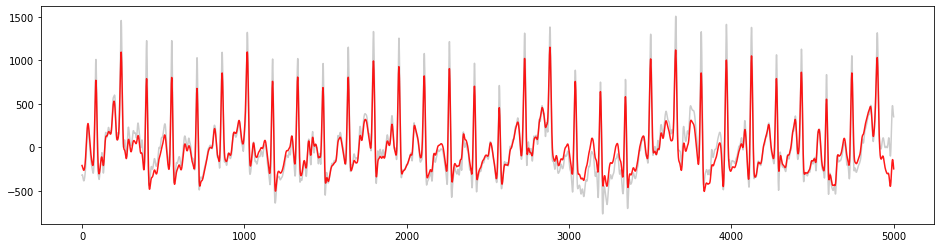

Heart rate | mean: 193 | std: 1.2


In [113]:
run_id = 'COVID32911_RUN20211227094855.870'

raw_signal = np.loadtxt('../data/interim/ecg_runs_covid/' + run_id + '.txt', skiprows=12)
raw_signal = raw_signal[1, :]  # Lead II
signals, info = nk.ecg_process(raw_signal, sampling_rate=int(os.environ['SAMPLING_RATE']))
print(signals.keys())

cleaned_signal = signals['ECG_Clean']

plt.figure(figsize=(16, 4))
plt.plot(raw_signal, c='gray', alpha=0.4)
plt.plot(cleaned_signal, c='red', alpha=0.9)
qpeaks = signals['ECG_Q_Peaks']
qpeaks = qpeaks[qpeaks == 1].index
print(qpeaks)
# for qp in qpeaks:
    # plt.scatter(qp, cleaned_signal[qp])
plt.show() 


print(f"Heart rate | mean: {signals['ECG_Rate'].mean():.0f} | std: {signals['ECG_Rate'].std():.1f}")

### Find R Peaks and compute R intervals

In [121]:
print(f"Found {len(info['ECG_R_Peaks'])} R peaks")
print(info['ECG_R_Peaks'])



print("RR Intervals:", compute_rr_intervals(info['ECG_R_Peaks']))
print(f"Mean: {rr_intervals.mean():.0f} ms")
print(f"Std:  {rr_intervals.std():.0f} ms")

Found 31 R peaks
[ 241  398  553  708  863 1018 1174 1328 1484 1639 1795 1952 2108 2263
 2417 2570 2726 2882 3038 3193 3347 3502 3656 3812 3969 4123 4277 4431
 4585 4742 4897]
RR Intervals: [157 155 155 155 155 156 154 156 155 156 157 156 155 154 153 156 156 156
 155 154 155 154 156 157 154 154 154 154 157 155]
Mean: 655 ms
Std:  318 ms


In [120]:
# investigate HRV
nk.hrv(signals['ECG_R_Peaks'], sampling_rate=int(os.environ['SAMPLING_RATE']))

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSE,HRV_CMSE,HRV_RCMSE,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,310.4,2.19089,NaN,NaN,NaN,NaN,NaN,NaN,2.87678,2.924333,...,1.673976,2.089246,1.348528,NaN,NaN,NaN,0.644338,1.756162,2.614656,1.144941


### Visualize MFCC features

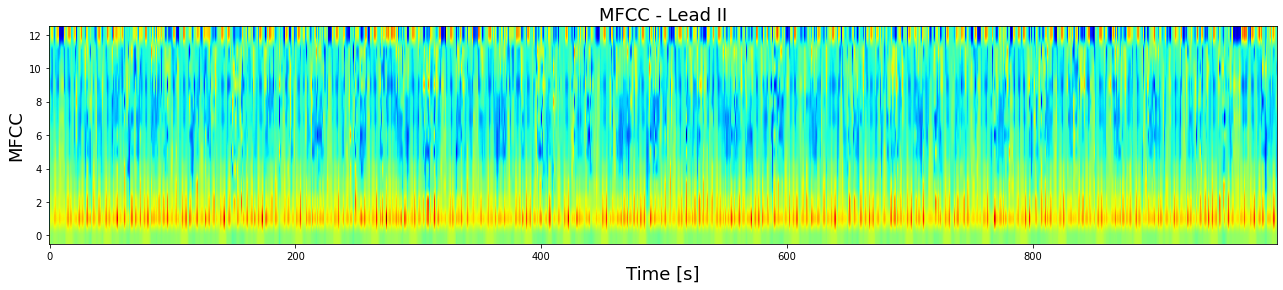

In [31]:
sample_rate = int(os.environ['SAMPLING_RATE'])

mfcc = np.load(f'../data/interim/ecg_runs_mfcc_covid/{run_id}_mfcc.npy')
mfcc = mfcc[1, :, :]  # Lead II
mfcc = mfcc.T

plt.figure(figsize=(22, 4))
plt.title('MFCC - Lead II',fontsize=18)
plt.imshow(mfcc, cmap=plt.cm.jet, aspect='auto',origin='lower')
plt.xlabel('Time [s]',fontsize=18)
plt.ylabel('MFCC',fontsize=18)
plt.show()

In [104]:
runs = pd.read_csv('../data/interim/ecg_runs.csv', index_col=0)
print(runs.ecg_type.value_counts())
runs = runs.loc[runs.ecg_type == 'Belastungs']
print()
print(runs.ecg_length.value_counts())
runs = runs.loc[runs.ecg_length == 5000]

print(runs.pat_group.value_counts())

Belastungs    1622
Ruhe           347
Name: ecg_type, dtype: int64

5000      1372
1390         4
870          4
1090         4
780          3
          ... 
1690         1
362320       1
143930       1
200430       1
190050       1
Name: ecg_length, Length: 211, dtype: int64
COVID        570
POSTCOVID    515
CTRL         287
Name: pat_group, dtype: int64


In [122]:
def compute_rr_intervals(rpeaks:list):
    if len(rpeaks) < 2:
        return []  # abort
    rr_intervals = []
    for left_peak_i in range(0, len(rpeaks) - 1):
        right_peak_i = left_peak_i + 1
        rr_intervals.append(rpeaks[right_peak_i] - rpeaks[left_peak_i])
    rr_intervals = np.array(rr_intervals)
    return rr_intervals


def get_rr_interval_mean_std(pat_group, sample_size=100):
    rr_intervals_mean_std = []

    for _run in tqdm(runs.loc[runs.pat_group == pat_group].sample(n=sample_size).itertuples(index=True), desc="Processing files", total=sample_size):
        # load and clean ECG signal
        raw_signal = np.loadtxt(f"../data/interim/ecg_runs_{_run.pat_group.lower()}/{_run.Index}.txt", skiprows=12)
        raw_signal = raw_signal[1, :]  # Lead II

        try:
            signals, info = nk.ecg_process(raw_signal, sampling_rate=int(os.environ['SAMPLING_RATE']))
        except:
            continue

        rr_intervals = compute_rr_intervals(info['ECG_R_Peaks'])
        rr_intervals_mean_std.append((rr_intervals.mean(), rr_intervals.std()))

    rr_intervals_mean_std = np.vstack(rr_intervals_mean_std)
    return rr_intervals_mean_std[:,0], rr_intervals_mean_std[:,1]


covid_rr_mean, covid_rr_std = get_rr_interval_mean_std(pat_group='COVID', sample_size=50)
postcovid_rr_mean, postcovid_rr_std = get_rr_interval_mean_std(pat_group='POSTCOVID', sample_size=50)
ctrl_rr_mean, ctrl_rr_std = get_rr_interval_mean_std(pat_group='CTRL', sample_size=50)

Processing files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing files:   0%|          | 0/50 [00:00<?, ?it/s]

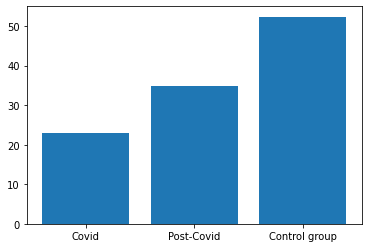

In [112]:
plt.figure()
plt.bar(['Covid', 'Post-Covid', 'Control group'], [covid_rr_std, postcovid_rr_std, ctrl_rr_std])
plt.show()

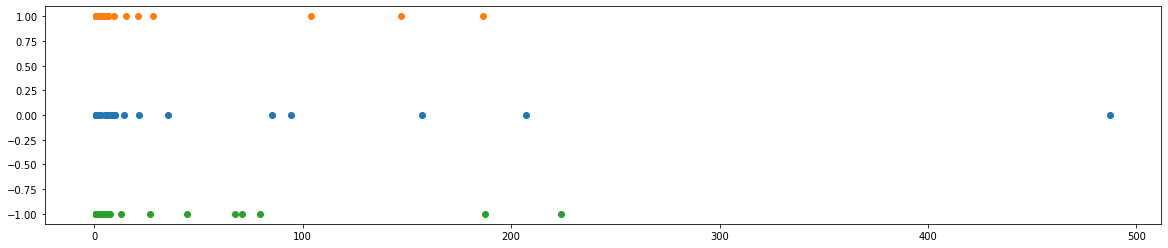

In [126]:
plt.figure(figsize=(20, 4))
plt.scatter(covid_rr_std, np.zeros(len(covid_rr_std)))
plt.scatter(postcovid_rr_std, np.ones(len(postcovid_rr_std)))
plt.scatter(ctrl_rr_std, -np.ones(len(ctrl_rr_std)))
plt.show()